# AIR POLLUTION IN DELHI 

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


In [2]:

# 2. Load Dataset
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df.head()


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


Data Cleaning and Pre-Processing 

In [9]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with missing date
df.dropna(subset=['date'], inplace=True)

# Extract time features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Define season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)

# View missing values
df.isnull().mean().sort_values(ascending=False)


pm2_5                          0.978625
spm                            0.544781
agency                         0.343048
stn_code                       0.330646
rspm                           0.092302
so2                            0.079505
location_monitoring_station    0.063084
no2                            0.037247
type                           0.012370
sampling_date                  0.000000
location                       0.000000
state                          0.000000
date                           0.000000
year                           0.000000
month                          0.000000
day                            0.000000
season                         0.000000
dtype: float64

Exploratory Data Analysis

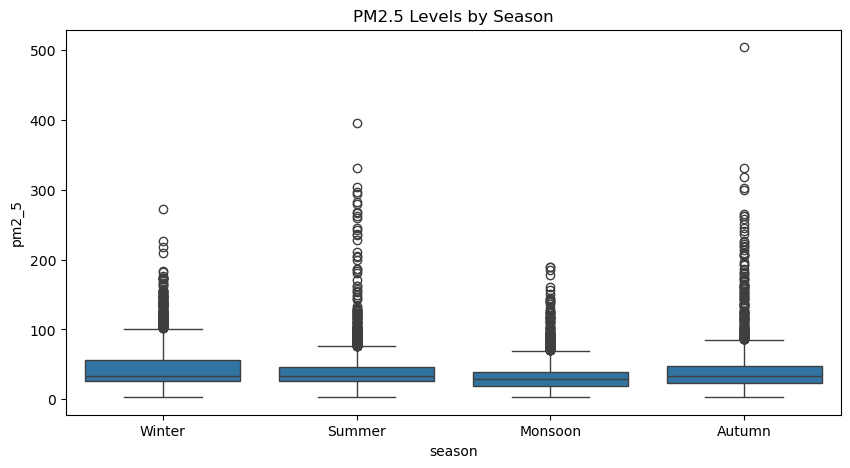

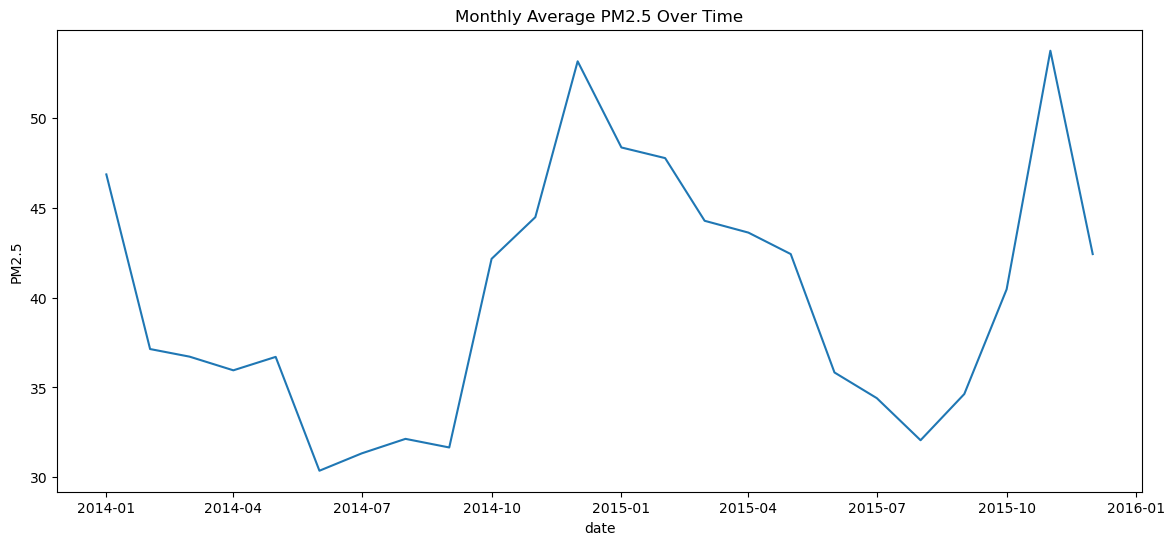

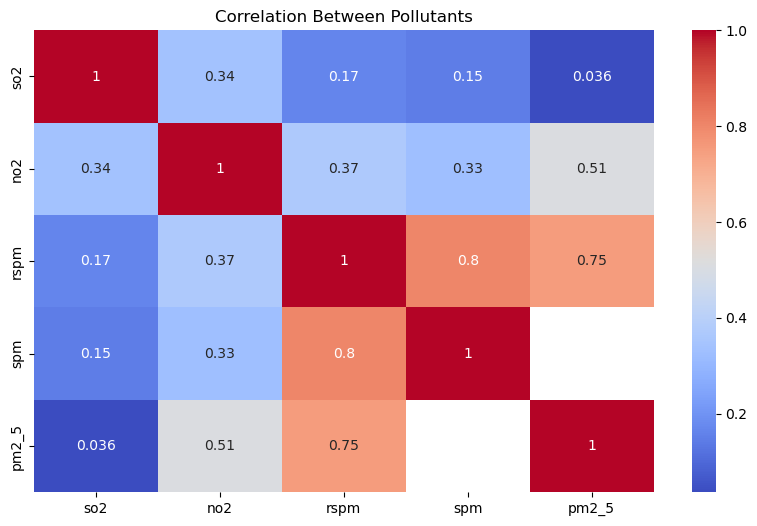

In [11]:
# Seasonal trend of PM2.5
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='season', y='pm2_5')
plt.title('PM2.5 Levels by Season')
plt.show()

# Time-series plot
monthly_avg = df.groupby(['year', 'month'])['pm2_5'].mean().reset_index()
monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_avg, x='date', y='pm2_5')
plt.title('Monthly Average PM2.5 Over Time')
plt.ylabel('PM2.5')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[['so2', 'no2', 'rspm', 'spm', 'pm2_5']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Pollutants')
plt.show()


Feature Engineering : AQI Selection

In [14]:
# Drop rows with missing PM2.5 (main pollutant)
df_model = df.dropna(subset=['pm2_5'])

# Create AQI categories based on CPCB thresholds
def classify_aqi(pm25):
    if pm25 <= 50:
        return 'Good'
    elif pm25 <= 100:
        return 'Satisfactory'
    elif pm25 <= 200:
        return 'Moderate'
    elif pm25 <= 300:
        return 'Poor'
    elif pm25 <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

df_model['AQI_Category'] = df_model['pm2_5'].apply(classify_aqi)

# Encode category labels
le = LabelEncoder()
df_model['AQI_Label'] = le.fit_transform(df_model['AQI_Category'])

df_model[['pm2_5', 'AQI_Category', 'AQI_Label']].head()


,pm2_5,AQI_Category,AQI_Label
65036,35.0,Good,0
65037,32.0,Good,0
65038,35.0,Good,0
65039,24.0,Good,0
65040,32.0,Good,0


Model Building [ Classification ] 

In [17]:
# Features and labels
features = ['so2', 'no2', 'rspm', 'spm']
X = df_model[features].fillna(0)
y = df_model['AQI_Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


[[2074    9    0  121    0    0]
 [  17   41    4   63    0    0]
 [   1    2    0    3    0    0]
 [ 125   24    0  308    0    0]
 [   0    0    1    0    0    0]
 [   0    1    1    0    0    0]]
              precision    recall  f1-score   support

        Good       0.94      0.94      0.94      2204
    Moderate       0.53      0.33      0.41       125
        Poor       0.00      0.00      0.00         6
Satisfactory       0.62      0.67      0.65       457
      Severe       0.00      0.00      0.00         1
   Very Poor       0.00      0.00      0.00         2

    accuracy                           0.87      2795
   macro avg       0.35      0.32      0.33      2795
weighted avg       0.86      0.87      0.86      2795



Feature Importance 

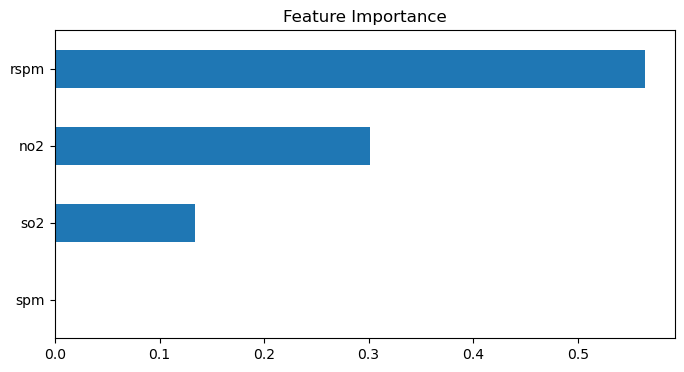

In [20]:
# Visualize feature importance
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(8, 4))
plt.title('Feature Importance')
plt.show()


Real - World Insights 

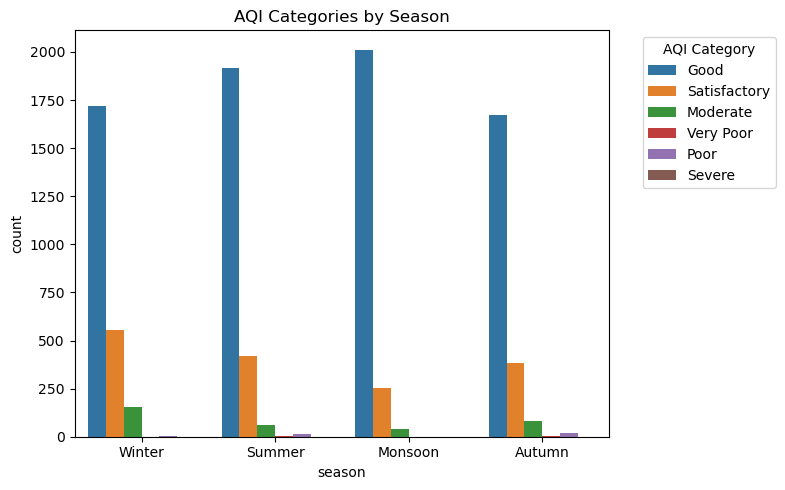

In [23]:
# Example: Count of AQI categories per season
plt.figure(figsize=(8,5))
sns.countplot(data=df_model, x='season', hue='AQI_Category', order=['Winter','Summer','Monsoon','Autumn'])
plt.title('AQI Categories by Season')
plt.legend(title='AQI Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
